Install dependencies

In [9]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

Import Aim

In [3]:
from aim import Run

Load the dataset

In [11]:
# Hyper parameters
batch_size = 100
num_classes = 10
learning_rate = 0.01
num_epochs = 1

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data/", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = torchvision.datasets.MNIST(
    root="./data/", train=False, transform=transforms.ToTensor()
)

# Data loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

Build CNN model

In [12]:
# Convolutional neural network (two convolution layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

Initialize model and optimizer

In [13]:
model = ConvNet(num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Train the model and track metrics and params with Aim

In [14]:
# Initialize a new Aim run
aim_run = Run(experiment="MNIST dataset")

# aim - Track hyper parameters
aim_run["hparams"] = {
    "num_epochs": num_epochs,
    "num_classes": num_classes,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
}

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 30 == 0:
            print(
                "Epoch [{}/{}], Step [{}/{}], "
                "Loss: {:.4f}".format(
                    epoch + 1, num_epochs, i + 1, total_step, loss.item()
                )
            )

            # aim - Track model loss function
            aim_run.track(
                loss.item(), name="loss", epoch=epoch, context={"subset": "train"}
            )

            correct = 0
            total = 0
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            acc = 100 * correct / total

            # aim - Track metrics
            aim_run.track(
                acc, name="accuracy", epoch=epoch, context={"subset": "train"}
            )

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images
        labels = labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 5 == 0:
            acc = 100 * correct / total
            aim_run.track(acc, name="accuracy", context={"subset": "test"})

aim_run.finalize()

Epoch [1/1], Step [1/600], Loss: 2.7404
Epoch [1/1], Step [31/600], Loss: 0.5194
Epoch [1/1], Step [61/600], Loss: 0.2633
Epoch [1/1], Step [91/600], Loss: 0.1240
Epoch [1/1], Step [121/600], Loss: 0.0954
Epoch [1/1], Step [151/600], Loss: 0.2282
Epoch [1/1], Step [181/600], Loss: 0.0705
Epoch [1/1], Step [211/600], Loss: 0.0717
Epoch [1/1], Step [241/600], Loss: 0.0555
Epoch [1/1], Step [271/600], Loss: 0.1837
Epoch [1/1], Step [301/600], Loss: 0.0979
Epoch [1/1], Step [331/600], Loss: 0.0626
Epoch [1/1], Step [361/600], Loss: 0.0606
Epoch [1/1], Step [391/600], Loss: 0.0681
Epoch [1/1], Step [421/600], Loss: 0.0821
Epoch [1/1], Step [451/600], Loss: 0.0709
Epoch [1/1], Step [481/600], Loss: 0.0203
Epoch [1/1], Step [511/600], Loss: 0.0992
Epoch [1/1], Step [541/600], Loss: 0.1558
Epoch [1/1], Step [571/600], Loss: 0.0801


## Read, export, visualize




In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from aim import Repo

Initialize Aim repo

In [16]:
repo = Repo(".")

In [17]:
for run in repo.iter_runs():
    df = run.dataframe()
    display(df)
    break

,hash,name,description,archived,creation_time,end_time,active,experiment,tags,hparams.batch_size,hparams.learning_rate,hparams.num_classes,hparams.num_epochs
0,10a25d8f54284b029af5ed28,Run: 10a25d8f54284b029af5ed28,None,False,1.725299e+09,1.725299e+09,False,MNIST dataset,[],100,0.01,10,1


Search and retrieve training results

In [18]:
# Query metrics
query = "metric.name in ['accuracy', 'loss'] and run.hparams.learning_rate > 0"

# Convert results into pandas dataframe
for run_metrics_col in repo.query_metrics(query).iter_runs():
    df = run_metrics_col.dataframe(only_last=True, include_run=False)
    display(df)

  0%|          | 0/3 [00:00<?, ?it/s]

,idx,step,value,epoch,time,metric.name,metric.context.subset
0,0,12,98.000000,0,2024-09-02 23:26:09.105337,accuracy,train
0,0,12,0.060586,0,2024-09-02 23:26:09.104375,loss,train
0,0,12,98.098361,None,2024-09-02 23:26:20.947427,accuracy,test


 67%|██████▋   | 2/3 [00:00<00:00,  3.07it/s]

,idx,step,value,epoch,time,metric.name,metric.context.subset
0,0,62,95.000000,1,2024-09-02 18:19:07.143747,accuracy,train
0,0,62,0.196697,1,2024-09-02 18:19:07.142758,loss,train
0,0,24,97.954545,None,2024-09-02 18:19:54.992580,accuracy,test


100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

,idx,step,value,epoch,time,metric.name,metric.context.subset
0,0,62,100.000000,1,2024-09-02 18:13:32.638333,accuracy,train
0,0,62,0.016488,1,2024-09-02 18:13:32.636712,loss,train
0,0,24,98.016529,None,2024-09-02 18:13:46.350709,accuracy,test


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Retrieve training results with related hyper-parameters

In [19]:
# Query metrics
query = "metric.name in ['accuracy', 'loss'] and run.hparams.learning_rate > 0"

# Convert results into pandas dataframe
for run_metrics_col in repo.query_metrics(query).iter_runs():
    df = run_metrics_col.dataframe(only_last=True, include_run=True)
    display(df)

  0%|          | 0/3 [00:00<?, ?it/s]

,idx,step,value,epoch,time,run.hash,run.hparams.batch_size,run.hparams.learning_rate,run.hparams.num_classes,run.hparams.num_epochs,metric.name,metric.context.subset
0,0,12,98.000000,0,2024-09-02 23:26:09.105337,10a25d8f54284b029af5ed28,100,0.01,10,1,accuracy,train
0,0,12,0.060586,0,2024-09-02 23:26:09.104375,10a25d8f54284b029af5ed28,100,0.01,10,1,loss,train
0,0,12,98.098361,None,2024-09-02 23:26:20.947427,10a25d8f54284b029af5ed28,100,0.01,10,1,accuracy,test


,idx,step,value,epoch,time,run.hash,run.hparams.batch_size,run.hparams.learning_rate,run.hparams.num_classes,run.hparams.num_epochs,metric.name,metric.context.subset
0,0,62,95.000000,1,2024-09-02 18:19:07.143747,76b009d85c7f48149924e577,40,0.01,10,3,accuracy,train
0,0,62,0.196697,1,2024-09-02 18:19:07.142758,76b009d85c7f48149924e577,40,0.01,10,3,loss,train
0,0,24,97.954545,None,2024-09-02 18:19:54.992580,76b009d85c7f48149924e577,40,0.01,10,3,accuracy,test


,idx,step,value,epoch,time,run.hash,run.hparams.batch_size,run.hparams.learning_rate,run.hparams.num_classes,run.hparams.num_epochs,metric.name,metric.context.subset
0,0,62,100.000000,1,2024-09-02 18:13:32.638333,e2b6733b22494a90b6ec71c2,50,0.01,10,2,accuracy,train
0,0,62,0.016488,1,2024-09-02 18:13:32.636712,e2b6733b22494a90b6ec71c2,50,0.01,10,2,loss,train
0,0,24,98.016529,None,2024-09-02 18:13:46.350709,e2b6733b22494a90b6ec71c2,50,0.01,10,2,accuracy,test


100%|██████████| 3/3 [00:00<00:00, 27.89it/s]


Collect metrics full data

In [20]:
query = "metric.name == 'accuracy' and run.hparams.learning_rate > 0"
for run_metrics_col in repo.query_metrics(query).iter_runs():
    df = run_metrics_col.dataframe(only_last=True)
    display(df)

  0%|          | 0/3 [00:00<?, ?it/s]

,idx,step,value,epoch,time,run.hash,run.hparams.batch_size,run.hparams.learning_rate,run.hparams.num_classes,run.hparams.num_epochs,metric.name,metric.context.subset
0,0,12,98.000000,0,2024-09-02 23:26:09.105337,10a25d8f54284b029af5ed28,100,0.01,10,1,accuracy,train
0,0,12,98.098361,None,2024-09-02 23:26:20.947427,10a25d8f54284b029af5ed28,100,0.01,10,1,accuracy,test


,idx,step,value,epoch,time,run.hash,run.hparams.batch_size,run.hparams.learning_rate,run.hparams.num_classes,run.hparams.num_epochs,metric.name,metric.context.subset
0,0,62,95.000000,1,2024-09-02 18:19:07.143747,76b009d85c7f48149924e577,40,0.01,10,3,accuracy,train
0,0,24,97.954545,None,2024-09-02 18:19:54.992580,76b009d85c7f48149924e577,40,0.01,10,3,accuracy,test


,idx,step,value,epoch,time,run.hash,run.hparams.batch_size,run.hparams.learning_rate,run.hparams.num_classes,run.hparams.num_epochs,metric.name,metric.context.subset
0,0,62,100.000000,1,2024-09-02 18:13:32.638333,e2b6733b22494a90b6ec71c2,50,0.01,10,2,accuracy,train
0,0,24,98.016529,None,2024-09-02 18:13:46.350709,e2b6733b22494a90b6ec71c2,50,0.01,10,2,accuracy,test


100%|██████████| 3/3 [00:00<00:00, 33.87it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

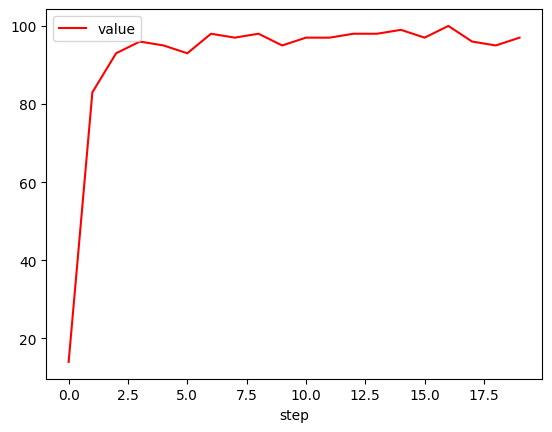

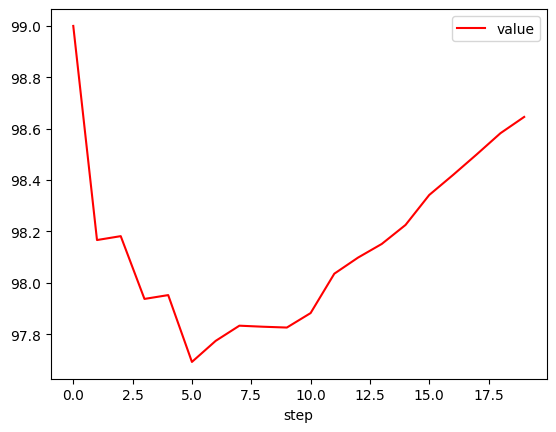

 67%|██████▋   | 2/3 [00:00<00:00,  4.85it/s]

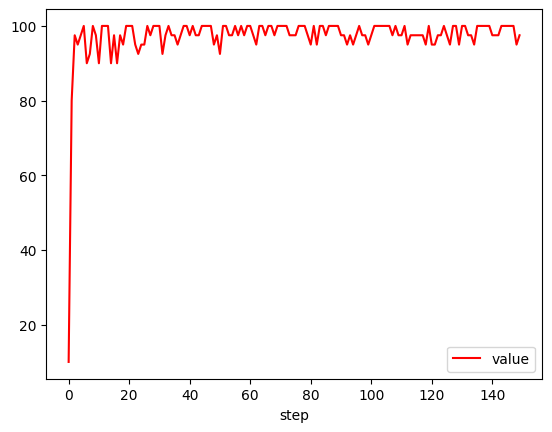

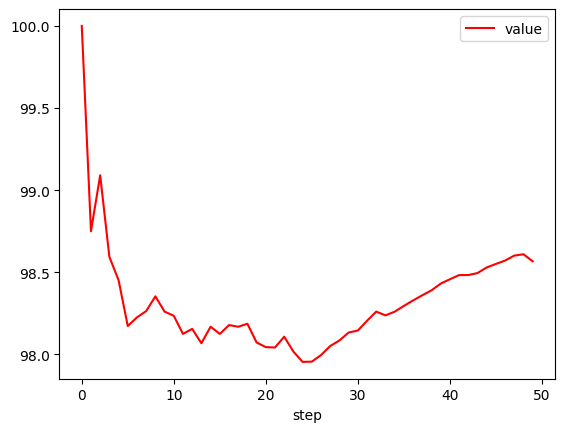

100%|██████████| 3/3 [00:00<00:00,  3.73it/s]

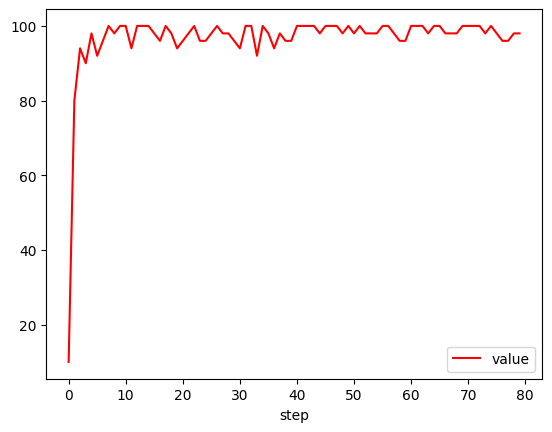

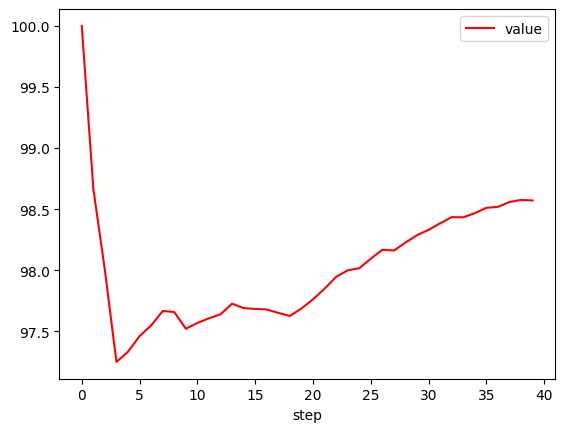

100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


In [21]:
# Plot metrics
query = "metric.name == 'accuracy' and metric.context.subset in ['train', 'test'] and run.hparams.learning_rate > 0"
for run_metrics_col in repo.query_metrics(query).iter_runs():
    for metric in run_metrics_col.iter():
        df = metric.dataframe()
        df.plot(kind="line", x="step", y="value", color="red")
        plt.show()

Plot metrics grouped by runs

  0%|          | 0/3 [00:00<?, ?it/s]

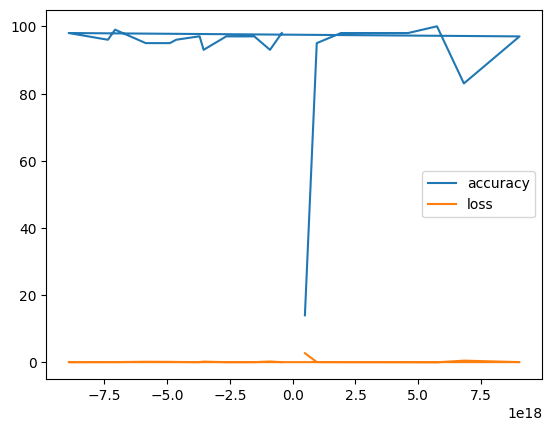

 67%|██████▋   | 2/3 [00:00<00:00,  9.39it/s]

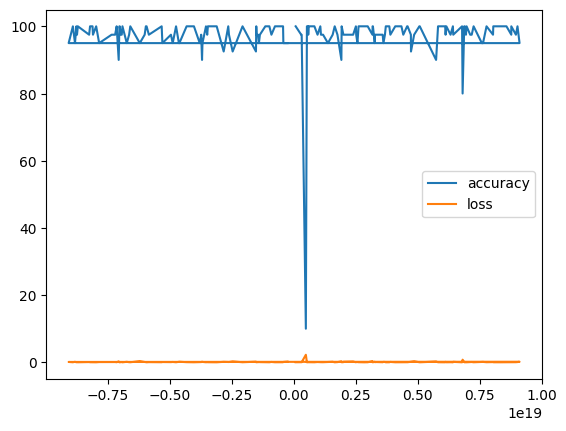

100%|██████████| 3/3 [00:00<00:00,  6.52it/s]

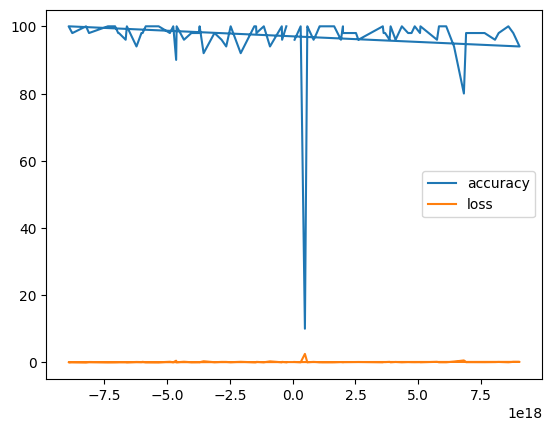

100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


In [22]:
import matplotlib.pyplot as plt

query = "metric.name in ['accuracy', 'loss'] and metric.context.subset == 'train' and run.hparams.learning_rate > 0"

for run_metrics_col in repo.query_metrics(query).iter_runs():
    for metric in run_metrics_col:
        steps, values = metric.values.sparse_list()
        plt.plot(steps, values, label=metric.name)
    plt.legend()
    plt.show()

Plot metrics grouped by training phase

  0%|          | 0/3 [00:00<?, ?it/s]

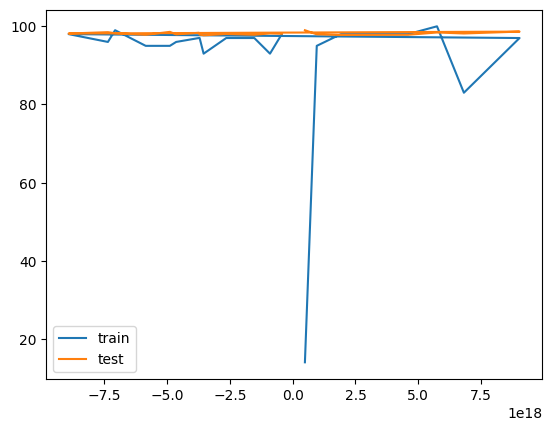

 67%|██████▋   | 2/3 [00:00<00:00, 10.80it/s]

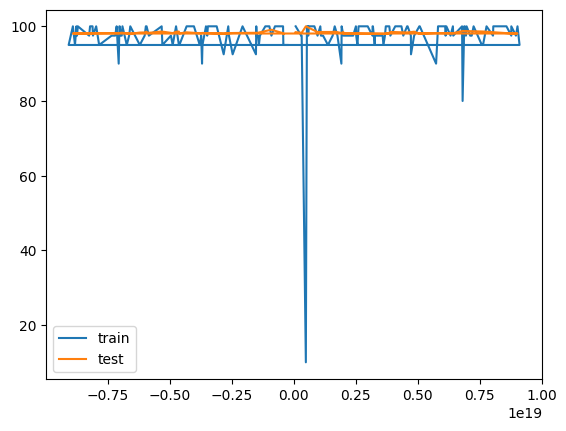

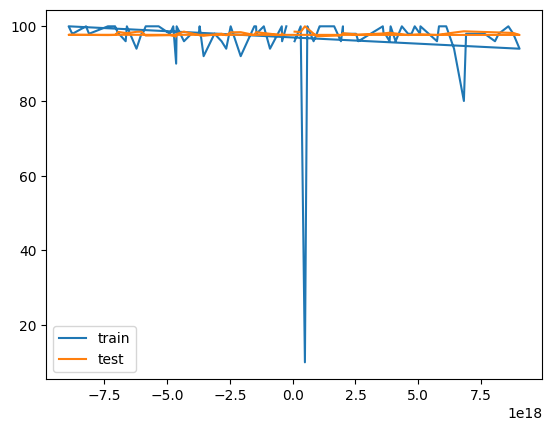

100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


In [23]:
import matplotlib.pyplot as plt

query = "metric.name in ['accuracy'] and metric.context.subset in ['train', 'test'] and run.hparams.learning_rate > 0"

for run_metrics_col in repo.query_metrics(query).iter_runs():
    for metric in run_metrics_col:
        steps, values = metric.values.sparse_list()
        plt.plot(steps, values, label=metric.context["subset"])
    plt.legend()
    plt.show()

In [24]:
import sqlite3

conn = sqlite3.connect(".aim/run_metadata.sqlite")

cursor = conn.cursor()

experiment_name = "MNIST dataset"

query = """
SELECT DISTINCT uuid 
FROM experiment 
WHERE name = ?
"""

cursor.execute(query, (experiment_name,))

uuid = cursor.fetchone()

print(uuid[0])

conn.close()

b875068f-d135-4980-94c1-c184da20bfd5
